In [283]:
# 1.Import necessary libraries and load the dataset and display random 5 samples. 
# Check the info of the data and write your findings. (2 points)
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# display settings
pd.options.display.max_columns = 16

# markdown
def printmd(string):
    display(Markdown(string))

# data
df = pd.read_csv('adult.csv')
sh = df.shape

# info the dataset
df.info()


# findings
print('''
At a first glimpse we have an idea of Categorical and Numerical features
Categorical features (object) {code : df['native.country'].nunique(), df.describe(include='object')}
    - workclass (9)
    - education (16)
    - marital.status (7)
    - occupation (15)
    - relationship (6)
    - race (5)
    - sex (2)
    - native.country (42)
    - income (2)
    
Numerical features (int)
    - age 
    - fnlwgt
    - education.num
    - capital.gain
    - capital.loss
    - hours.per.week

we can perform one-hot-encoding
    - sex (male:1, female:0)
    - income (<=50K:0, >50K:1)
    
we have missing values (?)
    - workclass      : 1836
    - occupation     : 1843
    - native.country : 583

''')

df.iloc[np.random.randint(0, sh[0], 5)]  # 5 random samples


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB

At a first glimpse we have an idea of Categorical and Numerical features
Categorical feature

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
15234,48,Private,76017,HS-grad,9,Widowed,Other-service,Unmarried,White,Female,0,0,25,United-States,<=50K
26879,33,Private,348592,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,>50K
12624,43,Private,252519,Bachelors,13,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,Haiti,>50K
15227,20,Private,299399,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K
7778,19,Private,430471,11th,7,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,40,United-States,<=50K


## EDA

In [284]:
#=================== Descriptive Statistics ======================#
Num = df.columns[df.applymap(np.isreal).apply(pd.unique).values[0]]
Cat = df.columns[~df.applymap(np.isreal).apply(pd.unique).values[0]]
Mean = df[Num].mean()
Median = df[Num].median()
Mode = df.mode()
Variance = df[Num].var()
Std_Dev = df[Num].std()
Coef_Var = Std_Dev[Num] / Mean[Num]
Minimum = df[Num].min()
Maximum = df[Num].max()
Range = Maximum[Num] - Minimum[Num]
Q1 = df[Num].quantile(0.25)
Q2 = df[Num].quantile(0.50)
Q3 = df[Num].quantile(0.75)
IQR = Q3[Num] - Q1[Num]
Adjusted_Q1 = Q1 - 1.5*IQR
Adjusted_Q3 = Q3 + 1.5*IQR
Outliers = df[(df[Num].apply(zscore) < -3.0) | (df[Num].apply(zscore) > 3.0)], df[(df < (Q1-1.5*IQR)) | (df > (Q3+1.5*IQR))]  # more accurate in iqr
Skew = df.skew(), np.array(list(map(lambda x: (
    x[0]-x[1])/x[2], zip(Mean, Variance, Std_Dev))))  # skew is accurate
Kurtosis = df[Num].kurtosis()
Sum = df[Num].sum()
Count = df[Num].count()
Missing = (df.isna().sum()) + (df[df == '?'].agg('count'))
# Left_Skewed = list(zip(df[Num][Skew[0] < 0], Skew[0][Skew[0] < 0]))
# Right_Skewed = list(zip(df[Num][Skew[0] > 0], Skew[0][Skew[0] > 0]))
# Symmetric = list(zip(df[Num][np.round(Skew[0]) == 0],
#                      Skew[0][np.round(Skew[0]) == 0]))
Covariance = df.cov()
Correlation = df.corr()

Normal_dist = df[Num].apply(zscore) # normality of the data # mean = 0, std = 1
P68 = Normal_dist[Num][(Normal_dist[Num] > (Normal_dist[Num].mean()-1*Normal_dist[Num].std()))
                       & (Normal_dist[Num] < (Normal_dist[Num].mean()+1*Normal_dist[Num].std()))]  # one standard_deviation away from the mean (x-s, x+s)
P95 = Normal_dist[Num][(Normal_dist[Num] > (Normal_dist[Num].mean()-2*Normal_dist[Num].std()))
                       & (Normal_dist[Num] < (Normal_dist[Num].mean()+2*Normal_dist[Num].std()))]  # two standard_deviation away from the mean (x-2*s, x+2*s)
P99 = Normal_dist[Num][(Normal_dist[Num] > (Normal_dist[Num].mean()-3*Normal_dist[Num].std()))
                       & (Normal_dist[Num] < (Normal_dist[Num].mean()+3*Normal_dist[Num].std()))]  # three standard_deviation away from the mean (x-3*s, x+3*s)

#============================ VIF =====================================#
# df1 = pd.DataFrame()
# df1['Feature'] = df[n].columns
# df1['vif'] = [vif(df[n].values, i) for i in range(len(df[n].columns))]
# print(df1)
# df1.index = df1.Feature
# df1.drop(['Feature'], axis=1, inplace=True)
# print(df1)

# PCA =

# representation
Mean
Median
Mode.loc[0]
Variance
Std_Dev
Coef_Var
Minimum
Maximum
Range
Q1
Q2
Q3
IQR
Adjusted_Q1
Adjusted_Q3
pd.Series(data=[len(Outliers[1][i].dropna().unique())
                for i in Num], index=Num)
Skew[0]
Kurtosis
Sum
Count
Missing
Left_Skewed
Right_Skewed
Symmetric
Covariance
Correlation

# Descriptive Statistics
stats = pd.DataFrame(data={'Mean': Mean, 'Median': Median, 'Mode': Mode.loc[0], 'Variance': Variance, 'Std': Std_Dev, 'Coef_Var': Coef_Var, 'Min': Minimum, 'Max': Maximum, 'Range': Range, 'Q1': Q1, 'Q2': Q2, 'Q3': Q3, 'IQR': IQR,
                                'Adjusted_Q1': Adjusted_Q1, 'Adjusted_Q3': Adjusted_Q3, 'Outliers': pd.Series(data=[len(Outliers[1][i].dropna().unique()) for i in Num], index=Num), 'Skewness': Skew[0], 'Kurtosis': Kurtosis, 'Sum': Sum, 'Count': Count, 'Missing': Missing}).T
stats

,age,capital.gain,capital.loss,education,education.num,fnlwgt,hours.per.week,income,marital.status,native.country,occupation,race,relationship,sex,workclass
Mean,38.581647,1077.648844,87.30383,NaN,10.080679,189778.366512,40.437456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Median,37.0,0.0,0.0,NaN,10.0,178356.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mode,36.0,0.0,0.0,HS-grad,9.0,123011,40.0,<=50K,Married-civ-spouse,United-States,Prof-specialty,White,Husband,Male,Private
Variance,186.0614,54542539.178405,162376.937814,NaN,6.61889,11140797791.841892,152.458995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Std,13.640433,7385.292085,402.960219,NaN,2.57272,105549.977697,12.347429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coef_Var,0.353547,6.853153,4.615608,NaN,0.255213,0.556175,0.305346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Min,17.0,0.0,0.0,NaN,1.0,12285.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max,90.0,99999.0,4356.0,NaN,16.0,1484705.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Range,73.0,99999.0,4356.0,NaN,15.0,1472420.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q1,28.0,0.0,0.0,NaN,9.0,117827.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [285]:
#================================ Visualization ====================================#
def histplot(df):
    #============== Histogram ==================#
    for i in df[Num]:
        plt.hist(df[i])
        plt.title(i)
        plt.show()


def scatplot(df):
    #============ Scatter Plot =============#
    from itertools import combinations as cb

    for x, y in cb(df[Num], 2):
        plt.scatter(df[x], df[y])
        plt.title(f'{x} vs {y}')
        plt.show()


def boxplot(df):
    #============= Box Plot ===============#
    for i in df[Num]:
        sns.boxplot(df[i])
        plt.title(i)
        plt.show()


def lineplot(df):
    #============= Line Chart ==============#
    for i in df[Num]:
        plt.plot(df[i])
        plt.title(i)
        plt.show()


def pieplot(df):
    #============= Pie Chart ================#
    for i in df[Cat]:
        plt.figure(figsize=(12, 10))
        j = df[i].value_counts()
        plt.pie(j.values, labels=j.index, autopct='%1.2f%%')
        plt.title(i)
        plt.show()


def heatmap(df):
    #============== Heat Map =================#
    plt.figure(figsize=(12, 10))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()


In [286]:
# Missing Data Detection : Median/Mean with Numerical | Mode with Categorical
missing = df[df == '?'].agg('count')
m = missing[missing>0].index  # finding missing features
v = df[m].mode()  # finding modes of those missing features
for i, j in enumerate(df[m].columns):
    i = v[j].values[0]
    df[j].replace({'?': i}, inplace=True)  # replaces with mode
# df

# one-hot-encoding : sex | income features
df.sex.value_counts()  # male (21790) | female (10771) => male = 1, female = 0
df.income.value_counts()  # <=50K (24720) | >50K (7841) => <50K = 1, >50K = 0

df.sex.replace({'Male': 1, 'Female': 0}, inplace=True)  # sex feature
df.income.replace({'<=50K': 1, '>50K': 0}, inplace=True)  # income feature

#================== Outlier detection ====================#
# checking the skewness before log_tranformation
# 'age', 'fnlwgt', 'education.num', 'sex', 'capital.gain', 'capital.loss','hours.per.week', 'income'
s = df.skew()  # skewness of the data
# boxplot(df[s.index]) # visualize the outliers (numerical)
outliers = df[(df < (df[Num].quantile(0.25)-1.5*(df[Num].quantile(0.75)-df[Num].quantile(0.25)))) |
              (df > (df[Num].quantile(0.75)+1.5*(df[Num].quantile(0.75)-df[Num].quantile(0.25))))]
o = [outliers[i].dropna().unique() for i in s.index]  # outliers for each features
# o 

# check the outlier percentage in each feature
data = (stats.loc['Outliers',:][Num]/stats.loc['Count',:][Num])*100
printmd('### Outlier percentage in the data')
for i,j in data.items():
    leng = ' ' * abs(20-len(i)) if len(i) < 40 else ' '*20  # spacing
    print(f'{i} {leng}: {round(j,2)}%')
print(f'fnlwgt has {round(data.max(),2)}% more outliers than other variables which are less.')

# Outlier treatment : There is no need in log_transformation because the data is less skewed
# Encoding : WOE(Weight Of Evidence) =>  measures how much the evidence supports or undermines a hypothesis

### Outlier percentage in the data

age                  : 0.03%
fnlwgt               : 2.57%
education.num        : 0.01%
capital.gain         : 0.36%
capital.loss         : 0.28%
hours.per.week       : 0.23%
fnlwgt has 2.57% more outliers than other variables which are less.


In [287]:
# 2.What is the average age of males and females in the data? (1 point)
# method 1
df.groupby('sex').age.mean().to_frame().reset_index(drop=False)

# method 2
pd.pivot_table(data=df[['sex','age']],index='sex',values='age',aggfunc={'age':np.mean},fill_value=0).reset_index() 

# method 3
sex = df.groupby('sex')
printmd('## Average age of males and females')
print("Average Age of Males: ", round(sex.get_group(1)['age'].mean(),2))
print("Average Age of Female: ", round(sex.get_group(0)['age'].mean(),2))

# method 4
sex.aggregate({'age': 'mean'}).rename({0:'Male',1:'Female'}).reset_index()


## Average age of males and females

Average Age of Males:  39.43
Average Age of Female:  36.86


,sex,age
0,Male,36.858230
1,Female,39.433547


"HS-grad" qualification is having most of the individual of 10501
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64


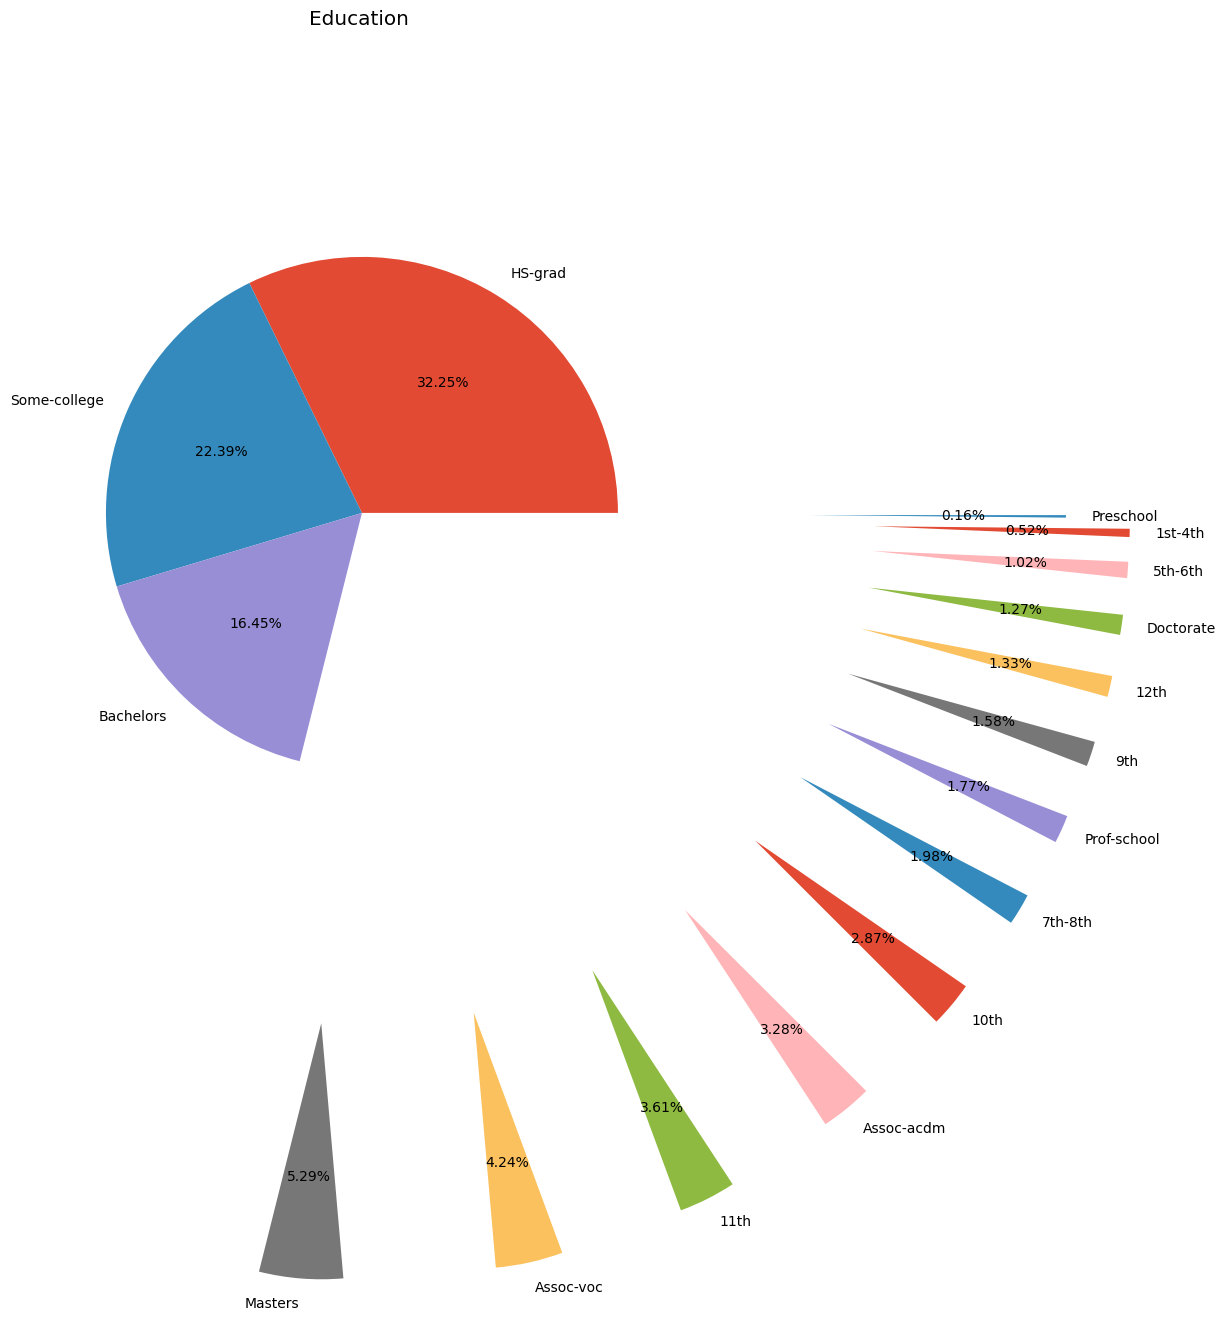

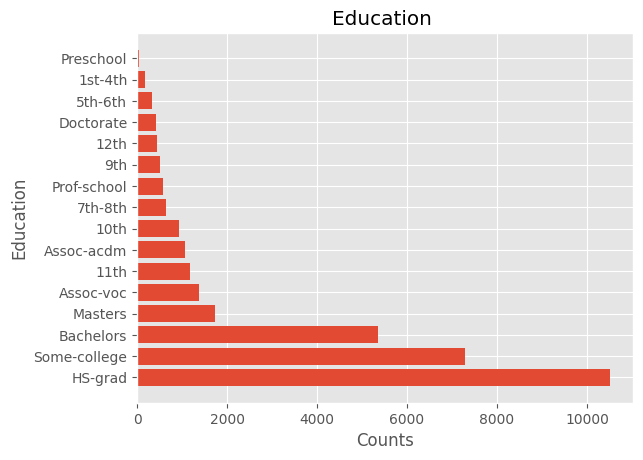

In [288]:
# 3.Identify the qualifications of most of the individuals and display it using an appropriate plot
print(f'"{df.education.mode()[0]}" qualification is having most of the individual of {df.education.value_counts()[0]}')

# plot
data = df.education.value_counts()
print(data)

fig = plt.figure()
ax = fig.add_axes([0,0,1,2])
ax.axis('equal')
ax.pie(data,labels=data.index,autopct='%1.2f%%', explode=[0,0,0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.75])
plt.title('Education ')
plt.show()

plt.barh(data.index,data.values)
plt.ylabel('Education')
plt.xlabel('Counts')
plt.title('Education ')
plt.show()

In [289]:
# 4.Find the middle most observation of age for different working classes. (1 point)
# method 1
pd.pivot_table(data=df,index='workclass',values='age',aggfunc={'age':np.median}).reset_index()

# method 2
work_class = df.groupby('workclass',group_keys=True)

# middle most observations
printmd('## Middle most observation of age for particular working classes')
for index in work_class.groups.keys():
    data = work_class.get_group(index)['age'].median()
    leng = ' ' * abs(20-len(index)) if len(index) < 40 else ' '*20 # spacing 
    print(f'class : {index}{leng}| age : {data}',end='\n\n')

## Middle most observation of age for particular working classes

class : Federal-gov         | age : 43.0

class : Local-gov           | age : 41.0

class : Never-worked        | age : 18.0

class : Private             | age : 35.0

class : Self-emp-inc        | age : 45.0

class : Self-emp-not-inc    | age : 44.0

class : State-gov           | age : 39.0

class : Without-pay         | age : 57.0



In [290]:
# 5.What is the percentage of the Asian-Pac-Islander race people in the data? (1 point)
race_with = df['race'][df['race']=='Asian-Pac-Islander'].agg('count')
race_without = df['race'][df['race']!='Asian-Pac-Islander'].agg('count')

# percentage
percent = race_with / (race_with + race_without)

# percentage
printmd('## Percentage of the Asian-Pac-Islander race people')
print('Counts of Race with Asian-Pac-Islander: ', race_with)
print('Counts of Race without Asian-Pac-Islander: ', race_without)
print(f'There are {round(percent*100,2)}% of the Asian-Pac-Islander race people in the data')

## Percentage of the Asian-Pac-Islander race people

Counts of Race with Asian-Pac-Islander:  1039
Counts of Race without Asian-Pac-Islander:  31522
There are 3.19% of the Asian-Pac-Islander race people in the data


In [291]:
# 6.Which occupation has more variability in the working hours? (1 point)
data = df[['hours.per.week','education']].groupby('education').agg('var').reset_index()
print(data)

# method 2
data = pd.pivot_table(data=df[['hours.per.week','education']],index='education',values='hours.per.week',aggfunc={'hours.per.week':np.var}).reset_index()
data = data[data['hours.per.week']==data['hours.per.week'].max()]
print(f'\n"{data.iloc[0,0]}" occupation has more variability in the working hours with {round(data.iloc[0,1],2)}')

       education  hours.per.week
0           10th      190.112046
1           11th      195.032844
2           12th      159.426289
3        1st-4th      165.089785
4        5th-6th      111.338941
5        7th-8th      201.693102
6            9th      122.420996
7     Assoc-acdm      148.758659
8      Assoc-voc      116.497148
9      Bachelors      131.015157
10     Doctorate      227.540551
11       HS-grad      128.454056
12       Masters      150.744394
13     Preschool      157.632941
14   Prof-school      219.218765
15  Some-college      162.866106

"Doctorate" occupation has more variability in the working hours with 227.54


In [303]:
# 7.What is the range of the middle 50% of working hours per week? (2 points) 
data = df['hours.per.week'].describe() # method 1 : data['50%']
data = df['hours.per.week'].quantile(0.50) # method 2
print(f"The range of middle 50% is {data} of working hours per week")

# range of the middle 50% = 0%-25% - 75%-100%
data = df['hours.per.week'].sort_values() # sorting the values 
# d1 = data.quantile(0)
# d2 = data.quantile(0.25)
# q2 = data.quantile(0.5), data.median()
# d3 = data.quantile(0.75)
# d4 = data.quantile(1.0)

# print(d1,d2,q2[1],d3,d4)

# d1 = data.iloc[np.where(data==d1)].index[0]
# d2 = data.iloc[np.where(data==d2)].index[0]
# d3 = data.iloc[np.where(data==d3)].index[0]
# d4 = data.iloc[np.where(data==d4)].index[-1]

# print(data[d1],d1)
# print(data[d2],d2)
# print(data[d3],d3)
# print(data[d4],d3)

# print(data[(data>d2) & (data<d3)]) # middle of 50%
# print(data.quantile(0.50))

# method 2
d1 = data.quantile(0.25)
d3 = data.quantile(0.75)

print(f'The range of middle 50% is {d3-d1} of working hours per week')

The range of middle 50% is 40.0 of working hours per week
The range of middle 50% is 5.0 of working hours per week


There is only one feature name "education.num" with a negative skewness of -0.31



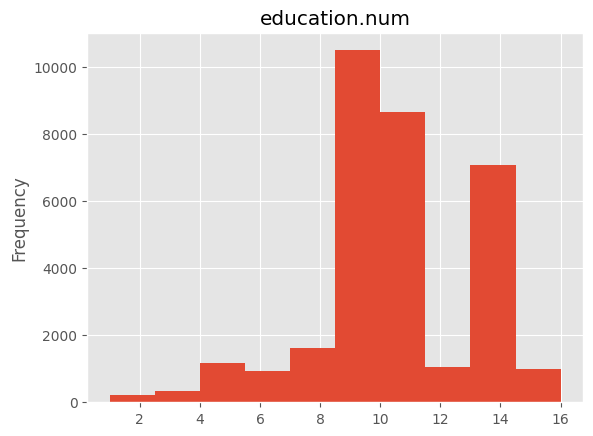

In [293]:
# 8. Are there any negatively skewed features? Support your answer with a metric and the plot. (2 points)
data = df.skew(numeric_only=True)
data = data[data < 0]

print(f'There is only one feature name "{data.index[0]}" with a negative skewness of {round(data[0],2)}\n')

# plot
df[data.index[0]].plot(kind='hist')
plt.title(data.index[0])
plt.show()

There are exactly 11 extreme values(outliers) in the age feature towards right/upper_bound
[90. 82. 83. 81. 80. 79. 88. 84. 85. 86. 87.]


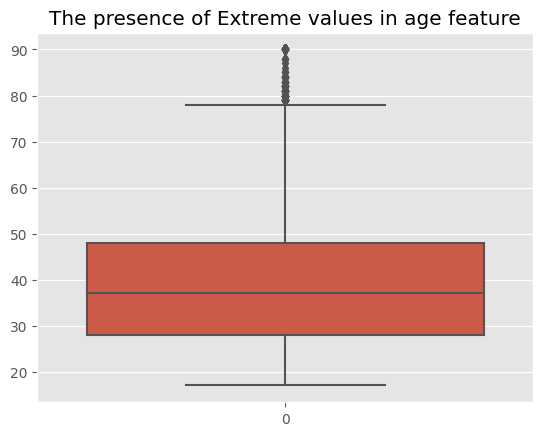

In [294]:
# 9.Identify the presence of extreme values in age using visualization techniques. (1 point)

print('There are exactly', len(outliers['age'].dropna().unique()), 'extreme values(outliers) in the age feature towards right/upper_bound')
print(outliers['age'].dropna().unique())  # outliers

# seaborn : boxplot, scatter_plot, z-scores, iqr
sns.boxplot(df['age']) # boxplot is efficient and clean to represent the outliers
plt.title('The presence of Extreme values in age feature')
plt.show()

we cannot say there is a cause and effect relationship between "age" on a particular working hours of a person
but we can say there is a association of 0.06876
Inorder to support the above theory we have to use linear regression to check whether there is any effect or not
The weight of the age towards hours.per.week is 0.06
so we can say,there is a increase in age the impact of hours.per.weeek is 0.06


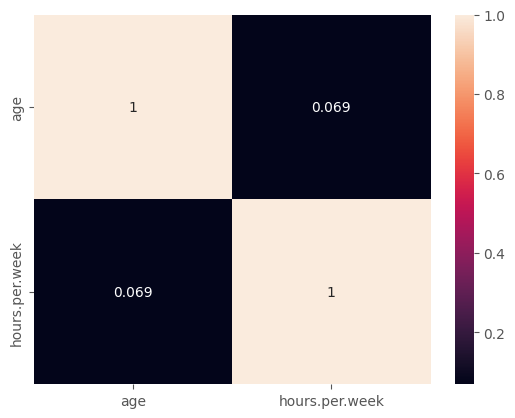

In [295]:
# 10.Is there any effect of age on the working hours of a person? Support your answer with a metric and the plot. (2 points)
data = df.corr()[['age','hours.per.week']].iloc[0,1].round(decimals=5)
print(f'we cannot say there is a cause and effect relationship between "age" on a particular working hours of a person') 
print(f'but we can say there is a association of {data}')
print('Inorder to support the above theory we have to use linear regression to check whether there is any effect or not')

# to support this i would like to use the linear regression analysis
x = df.age # independent on x-axis
y = df['hours.per.week'] # dependent on y-axis

# y = mx + c where m is slope(coefficient/weight) and c is constant(y-intercept)
# variables : age(x), hours.per.week(y)
cov_x_y = df.cov()['age']['hours.per.week']
var_x = df['age'].var()

# m (slope) 
m = cov_x_y/var_x
print(f'The weight of the age towards hours.per.week is {round(m,2)}')
print(f'so we can say,there is a increase in age the impact of hours.per.weeek is {round(m,2)}')

# plot : heat maps
sns.heatmap(df[['age', 'hours.per.week']].corr(), annot=True)
plt.show()

In [296]:
# 11.Is there any individual with age less than 18 and capital loss less than 100? (2 points)
data = df[(df['age']<18) & (df['capital.loss']<100)]

print(f'There are exactly "{data.shape[0]}" individuals with "age less than 18" and "capital loss less than 100"')

There are exactly "385" individuals with "age less than 18" and "capital loss less than 100"


"Craft-repair" occupation has the highest number of 3877 males.


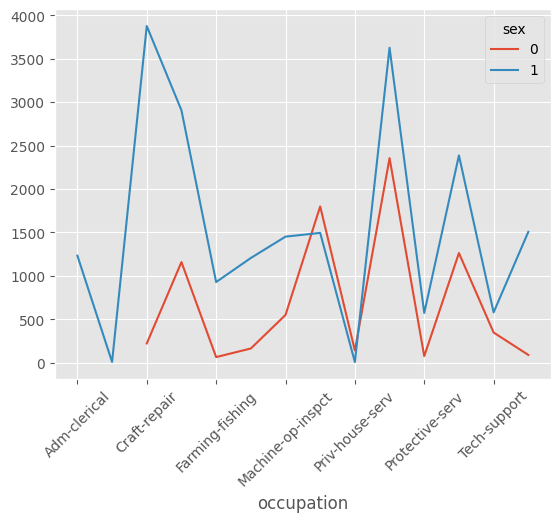

In [297]:
# 12.Which occupation has the highest number of males? (1 point)
# metric
data = df.groupby('occupation')
data = data['sex'].value_counts()[data['sex'].value_counts() == data['sex'].value_counts().max()]
print(f'"{data.index[0][0]}" occupation has the highest number of {data.iloc[0]} males.')

# visualisation 
data = df.groupby(['occupation'])['sex'].value_counts()
data.unstack().plot()
plt.xticks(rotation=45)
plt.show()

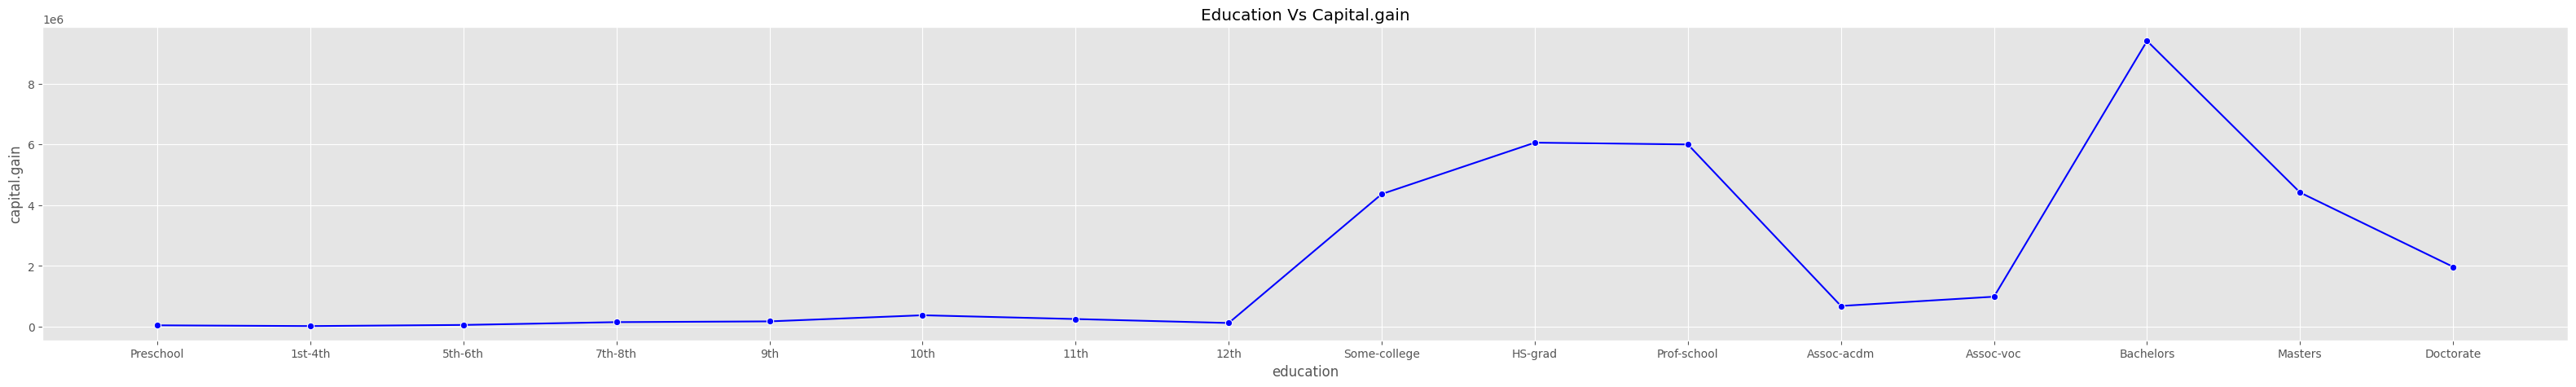


# Interpretation
- Bachelors education having more and high capital.gain of 9404984
- There is a turning point after 12th of sudden jump to 123010 there is capital.gain has improved gradually before it was linear and constant
- But there is drop after Prof-school which is 'Assoc-acdm','Assoc-voc' and after there is again jump in the bachelors
- We can say, those two categories are having a rough capital.gain 

# Conclusion
Through out education time-period
    - there is rough time in Assoc-acdm, Assoc-voc & Masters, Doctorate
    - there is good time after 12th and Assoc-voc



In [298]:
# 13.Analyze the trend of the capital gain amount for different educational qualifications and write your observations. (1 point)
# method 1
data = pd.pivot_table(data=df[['capital.gain','education']],index='education',values='capital.gain',aggfunc={'capital.gain':'sum'}).sort_values('capital.gain').reset_index()
data

# method 2
data = df.groupby('education')['capital.gain'].sum().reset_index()
data['education'] = pd.Categorical(data['education'], ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','Some-college','HS-grad','Prof-school','Assoc-acdm','Assoc-voc','Bachelors','Masters','Doctorate'])
# print(data)

# plot : line 
fig, ax = plt.subplots(figsize=(40, 5))
sns.lineplot(x=data['education'],y=data['capital.gain'],marker='o',color='b',ax=ax)
plt.title('Education Vs Capital.gain')
plt.show()

# observations
print('''
# Interpretation
- Bachelors education having more and high capital.gain of 9404984
- There is a turning point after 12th of sudden jump to 123010 there is capital.gain has improved gradually before it was linear and constant
- But there is drop after Prof-school which is 'Assoc-acdm','Assoc-voc' and after there is again jump in the bachelors
- We can say, those two categories are having a rough capital.gain 

# Conclusion
Through out education time-period
    - there is rough time in Assoc-acdm, Assoc-voc & Masters, Doctorate
    - there is good time after 12th and Assoc-voc
''')

In [310]:
# 14.Compare the working hours for each working class and write your observations. (1 point)
data = pd.pivot_table(data=df,index='workclass',values='hours.per.week',aggfunc={'hours.per.week':['count','sum','max','min','mean','median','var','std']}).T

# coefficent of variation : mean / std
m = df.groupby('workclass')['hours.per.week'].mean()
s = df.groupby('workclass')['hours.per.week'].std()

data = m / s
print(data.sort_values(ascending=False),end='\n\n')
print(f'On an average, The working class has {round(data.mean(),2)} working hours')

# observation
print("""
'?'                 : there are 1836 unknown individuals and worked on an average 31.92 and 50% is 36
'Federal-gov'       : there is no much difference between mean and median of 1.379167 and ranges from 4 - 99
'Local-gov'         : there is no much difference between mean and median of 0.9828 and ranges from 2 - 99
'Never-worked'      : there are extreme values in the data so the mean and median vary of 6.571429 and ranges from 4 - 40
'Private'           : there is no much difference between mean and median of 0.267096 and ranges from 1 - 99
'Self-emp-inc'      : there are extreme values in the data so the mean and median vary of 1.1819 and ranges from 1 - 99
'Self-emp-not-inc'  : there are extreme values in the data so the mean and median vary of 4.421881 and ranges from 1 - 99 
'State-gov'         : there is no much difference between mean and median of 0.968413 and ranges from 1 - 99
'Without-pay'       : there are extreme values in the data so the mean and median vary of 5.214286 and ranges from 10 - 65   
""")

print("""We can compare the working hours for each working class by coefficient of variation
- The Category "Federal-gov" is working higher than the remaining working class
- The Category "Never-worked" is working lower than the remaining working class
""")

workclass
Federal-gov         4.681640
Local-gov           3.804723
Self-emp-inc        3.511988
Private             3.366352
State-gov           3.336885
Self-emp-not-inc    2.663988
Without-pay         1.884691
Never-worked        1.872007
Name: hours.per.week, dtype: float64

On an average, The working class has 3.14 working hours

'?'                 : there are 1836 unknown individuals and worked on an average 31.92 and 50% is 36
'Federal-gov'       : there is no much difference between mean and median of 1.379167 and ranges from 4 - 99
'Local-gov'         : there is no much difference between mean and median of 0.9828 and ranges from 2 - 99
'Never-worked'      : there are extreme values in the data so the mean and median vary of 6.571429 and ranges from 4 - 40
'Private'           : there is no much difference between mean and median of 0.267096 and ranges from 1 - 99
'Self-emp-inc'      : there are extreme values in the data so the mean and median vary of 1.1819 and ranges from 1

In [331]:
# 15.Is there an all male profession according to the data? (1 point)
data = pd.pivot_table(df,index=['sex','occupation'],aggfunc='count').reset_index()

data = df.groupby(['occupation','sex'])['sex'].count()
print(data.to_frame()) # 0:Female 1:Male

d = {}
for i in data.index:
    if i[0] in d:
        d[i[0]].append(i[1])
    else:
        d[i[0]] = [i[1]]

# checking the one value
data = [(i,d[i][0],data[i][1]) for i in d if len(d[i])==1 and d[i][0]==1][0]
print(data)

# representation
print(f'There is an all male profession according to the data {data[0]} with count of {data[2]}')

                        sex
occupation        sex      
Adm-clerical      0    2537
                  1    1233
Armed-Forces      1       9
Craft-repair      0     222
                  1    3877
Exec-managerial   0    1159
                  1    2907
Farming-fishing   0      65
                  1     929
Handlers-cleaners 0     164
                  1    1206
Machine-op-inspct 0     550
                  1    1452
Other-service     0    1800
                  1    1495
Priv-house-serv   0     141
                  1       8
Prof-specialty    0    2356
                  1    3627
Protective-serv   0      76
                  1     573
Sales             0    1263
                  1    2387
Tech-support      0     348
                  1     580
Transport-moving  0      90
                  1    1507
('Armed-Forces', 1, 9)
There is an all male profession according to the data Armed-Forces with count of 9
